# Présentation Challenge Tuxae 2024
Le robot est une base différentielle, c'est à dire munie de deux roues motrices indépendantes. Pour aller tout droit les deux roues tournent dans le même sens à la même vitesse et pour tourner les roues tournent à vitesse différentes ou dans le sens opposé.   
L'objectif est d'estimer les trois valeures $(x, y, \alpha)$  

[https://github.com/Tuxae/ChallengeTuxae2024/](https://github.com/Tuxae/ChallengeTuxae2024/)

In [1]:
import pandas as pd
import numpy as np
from math import pi
import math as math

In [2]:
df = pd.read_csv("ligne_droite.csv", index_col=0)
df

,vx,vy,vrz,rot_g,rot_d,image,x,y,alpha
0,0.000000,0.000066,0.000000,0.000000,0.000000,000.png,0.225000,0.225001,-0.000000
1,0.153246,-0.000810,0.002323,3.120053,-3.123415,001.png,0.384353,0.225073,0.000785
2,0.078835,0.002848,0.052618,4.612360,-4.632692,002.png,0.463322,0.225617,0.019998
3,0.076039,0.000219,0.028701,6.091170,-6.122394,003.png,0.540326,0.226755,0.037680
4,0.073199,-0.001382,0.050622,7.573777,-7.608174,004.png,0.617558,0.228448,0.052976
5,0.078475,0.001987,0.017367,9.042129,-9.084502,005.png,0.694769,0.231400,0.069524
6,0.080799,0.008261,-0.015809,10.496015,-10.562298,006.png,0.771367,0.234786,0.087318
7,0.075678,0.006131,-0.007040,11.923313,-12.067926,007.png,0.848890,0.240449,0.101844
8,0.073962,0.006299,0.030275,13.404095,-13.677770,008.png,0.925447,0.243839,0.130543
9,0.078925,0.007407,0.032343,14.777149,-15.237526,009.png,1.003509,0.251151,0.154558


In [3]:
#Test sur tour de plateau

df2 = pd.read_csv("tour_du_plateau (1).csv",index_col = 0)

df2.head()

,vx,vy,vrz,rot_g,rot_d,image,x,y,alpha
0,0.000000,0.000066,0.000000,0.000000,0.000000,000.png,0.225000,0.225001,-0.000000
1,-0.015527,-0.005040,0.480258,-0.904679,-0.878508,001.png,0.226548,0.225264,0.459445
2,0.006663,0.012058,0.371563,-1.748032,-1.684530,002.png,0.224543,0.223378,0.913994
3,0.000072,0.001859,0.499627,-2.700744,-2.611544,003.png,0.225454,0.223259,1.392149
4,-0.001118,0.000588,0.203374,-3.263247,-3.323648,004.png,0.225504,0.224959,1.698283


L'objectif est donc d'estimer les 3 dernières colonnes $(x, y, \alpha)$ à partir des autres colonnes. On a également accès à la caméra et le robot se déplace sur un plateau de $3m\times 2m$. La position de départ du robot est $(0.225,0.225, 0)$ en (mètre, mètre, radian).


$indice$ est la seconde à laquelle la mesure a été faite (une mesure est faite toutes les secondes).    <br>
$vx$ et $vy$ sont les vitesses en m/s sur les axes respectifs $x$ et $y$.     <br>
$vrz$ est la vitesse de rotation en rad/s autour de l'axe $z$.    <br>
$rot\_g$ et $rot\_g$ sont l'angle en rad du moteur respectivement gauche et droit.    <br>
$image$ est le nom du fichier image.    <br>

### Filtre de Kalman (implémentation tirée de https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/)

In [4]:
#Paramètres 
dt = 1 #pas de temps
F = np.eye(3) #Matrice F dans le modèle Xt+1 = F*Xt + B*u
H = np.eye(3) #Matrice de mesure utilisée pour convertir les états estimés en états mesurés par les sensors au temps k 
R = np.eye(3) #Matrice bruit erreur de mesure à adapter en fonction de la confiance dans la mesure
Q = np.eye(3) #Matrice de bruit. Plus les entrées sont grandes, plus la variance des changements de mesures des sensors est gérée

In [5]:
#Modèle de déplacement utilisé pour prédire le prochain état 
#Paramètres position au temps t X = [x,y,theta] u = [v, omega]
#xt+1 = xt + vx cos(theta)
#yt+1 = yt + vy sin(theta) 
#theta_t+1 = theta_t + omega
#A adapter peut-être à notre problème
def motionModel(X,u) :
    B = np.array([[dt*math.cos(X[2]),0],[dt*math.sin(X[2]),0],[0,dt]])
    return (F@X) + (B@u)

In [6]:
#Modèle de déplacement utilisé pour prédire le prochain état 
#Paramètres position au temps t X = [x,y,theta] u = [vx, vy,omega]
#xt+1 = xt + vx cos(theta)
#yt+1 = yt + vy sin(theta) 
#theta_t+1 = theta_t + omega
#A adapter peut-être à notre problème
def motionModel2(X,u) :
    B = np.array([[u[0]*math.cos(X[2]),0,0],[0,u[1]*math.sin(X[2]),0],[0,0,1]])
    return (F@X) + (B@u)

In [7]:
#Prédiction du prochain état avant l' EKF
def prochainEtat(X,u) :
    bruit = np.array([0.01,0.01,0.003])

    return motionModel(X,u) + bruit

In [8]:
#Prédiction du prochain état avant l' EKF adaptation avec un vecteur de contrôle à 3 composantes
def prochainEtat2(X,u) :
    bruit = np.array([0.01,0.01,0.003])

    return motionModel2(X,u) + bruit

In [9]:
#Extended Kalman Filter

def ekf(posTriang,posprec,uk,covetatPrec) :
    #Estimation de l'état avant EKF : 
    posEstim = prochainEtat(posTriang,uk)
    #Calcul de la covariance de l'état 
    Pk = F @ covetatPrec @ F.T + Q
    #residu entre position donnée par la triangulation et la position estimée posEstim
    residu = posEstim - posTriang
    
    S = H @ Pk @ H.T + R
    
    #Initialisation de K
    K = Pk @ H.T @ np.linalg.pinv(S)
    
    # Update the state covariance estimate for time k
    Pk = Pk - (K @ H @ Pk)
    #Mise à jour de la position 

    posUpdate = posEstim + K@residu

    # Return the updated state and covariance estimates
    return posUpdate, Pk
    

In [10]:
#Extended Kalman Filter v2 avec les contrôles qui ont 3 composantes vx vy et omega

def ekf2(posreel,posprec,uk,covetatPrec) :
    #Estimation de l'état avant EKF : 
    posEstim = prochainEtat2(posprec,uk)
    #Calcul de la covariance de l'état 
    Pk = F @ covetatPrec @ F.T + Q
    #residu entre position réelle et la position estimée posEstim
    residu = posEstim - posreel
    
    S = H @ Pk @ H.T + R
    
    #Initialisation de K
    K = Pk @ H.T @ np.linalg.pinv(S)
    
    # Update the state covariance estimate for time k
    Pk = Pk - (K @ H @ Pk)
    #Mise à jour de la position 

    posUpdate = posEstim + K@residu

    # Return the updated state and covariance estimates
    return posUpdate, Pk


## Une idée simple d'intégration

In [23]:
df_est = df[['vx', 'vy', 'vrz', 'rot_g', 'rot_d', 'image']]
df_est.loc[:, ["alpha"]] = 0.0
df_est.loc[:, ["x", "y"]] = 0.225
n = len(df_est)
for i in range(n-1):
    df_est.at[i+1, "x"] = df_est.at[i, "x"] + df_est.at[i, "vx"]
    df_est.at[i+1, "y"] = df_est.at[i, "y"] + df_est.at[i, "vy"]
    df_est.at[i+1, "alpha"] = df_est.at[i, "alpha"] + df_est.at[i, "vrz"]

In [24]:
df_est.head()

,vx,vy,vrz,rot_g,rot_d,image,alpha,x,y
0,0.000000,0.000066,0.000000,0.000000,0.000000,000.png,0.000000,0.225000,0.225000
1,0.153246,-0.000810,0.002323,3.120053,-3.123415,001.png,0.000000,0.225000,0.225066
2,0.078835,0.002848,0.052618,4.612360,-4.632692,002.png,0.002323,0.378246,0.224255
3,0.076039,0.000219,0.028701,6.091170,-6.122394,003.png,0.054941,0.457081,0.227103
4,0.073199,-0.001382,0.050622,7.573777,-7.608174,004.png,0.083642,0.533120,0.227322


In [17]:
#Récupération des vitesses et position sur le premier dataframe lignedroite

pos = np.array(df.loc[:,["x","y","alpha"]])
control = np.array(df.loc[:,["vx","vy","vrz"]])

n = pos.shape[0]
posOptim = pos[0]
postabx = np.zeros(n)
postaby = np.zeros(n)
postalpha = np.zeros(n)
cov = np.eye(3)

#Exécution du filtre de Kalman sur liste des positions

for i in range(1,n) :
    posOptim, cov = ekf2(posOptim,pos[i],control[i],cov)
    postabx[i] = posOptim[0]
    postaby[i] = posOptim[1]
    postalpha[i] = posOptim[2] 


In [28]:
postalpha

array([0.        , 0.01018023, 0.11651247, 0.04020514, 0.14764137,
       0.05419857, 0.08706132, 0.10444366, 0.20051283, 0.18334307])

In [26]:
#Remplissage de df.est avec x, y et alpha 

for i in range(1,n) :
    df_est.at[i,"x"] = postabx[i]
    df_est.at[i,"y"] = postaby[i]
    df_est.at[i,"alpha"] = postalpha[i]


In [27]:
df_est.head()

,vx,vy,vrz,rot_g,rot_d,image,alpha,x,y
0,0.000000,0.000066,0.000000,0.000000,0.000000,000.png,0.000000,0.225000,0.225000
1,0.153246,-0.000810,0.002323,3.120053,-3.123415,001.png,0.010180,0.546396,0.241788
2,0.078835,0.002848,0.052618,4.612360,-4.632692,002.png,0.116512,0.437748,0.231760
3,0.076039,0.000219,0.028701,6.091170,-6.122394,003.png,0.040205,0.629372,0.239847
4,0.073199,-0.001382,0.050622,7.573777,-7.608174,004.png,0.147641,0.635095,0.237583


In [29]:
#Calcul du score 
resultat = 0
resultat += abs(pos[:,0] - postabx)/3
resultat += abs(pos[:,1] - postaby)/3
resultat += abs(pos[:,2] -postalpha)/3 % pi
resultat = 100*(1 - resultat)


print(f"Le score sur ligne droite est de {round(resultat.mean(), 2)} %")


Le score sur ligne droite est de 95.3 %


In [30]:
# N'oubliez pas de renommer la colonne d'indice "ID" et de mettre l'extension .csv
df_est[['x', 'y', 'alpha']].to_csv("sample_submission.csv", index_label="ID")

Un tel score est atteint parce que ce n'est qu'une ligne droite, le candidat peut intégrer en utilisant la méthode des trapèzes, utiliser la rotation des deux moteurs et réunir toutes les informations à l'aide du [filtre de Kalman](https://fr.wikipedia.org/wiki/Filtre_de_Kalman) 

In [31]:
#Récupération des vitesses et position sur le premier dataframe tour de plateau

pos = np.array(df2.loc[:,["x","y","alpha"]])
control = np.array(df2.loc[:,["vx","vy","vrz"]])

n = pos.shape[0]
posOptim = pos[0]
postabx = np.zeros(n)
postaby = np.zeros(n)
postalpha = np.zeros(n)
cov = np.eye(3)

#Exécution du filtre de Kalman sur liste des positions

for i in range(n) :
    posOptim, cov = ekf2(posOptim,pos[i],control[i],cov)
    postabx[i] = posOptim[0]
    postaby[i] = posOptim[1]
    postalpha[i] = posOptim[2] 

In [32]:
#Calcul du score 
resultat = 0
resultat += abs(pos[:,0] - postabx)/3
resultat += abs(pos[:,1] - postaby)/3
resultat += abs(pos[:,2] -postalpha)/3 % pi
resultat = 100*(1 - resultat)


print(f"Le score sur tour de plateau est de {round(resultat.mean(), 2)} %")


Le score sur tour de plateau est de 88.34 %


In [33]:
df_est2 = df[['vx', 'vy', 'vrz', 'rot_g', 'rot_d', 'image']]
df_est2.loc[:, ["alpha"]] = 0.0
df_est2.loc[:, ["x", "y"]] = 0.225
n = len(df_est2)
for i in range(n-1):
    df_est2.at[i+1, "x"] = df_est.at[i, "x"] + df_est.at[i, "vx"]
    df_est2.at[i+1, "y"] = df_est.at[i, "y"] + df_est.at[i, "vy"]
    df_est2.at[i+1, "alpha"] = df_est.at[i, "alpha"] + df_est.at[i, "vrz"]

In [34]:
#Remplissage de df_est2 avec x, y et alpha 

for i in range(1,n) :
    df_est2.at[i,"x"] = postabx[i]
    df_est2.at[i,"y"] = postaby[i]
    df_est2.at[i,"alpha"] = postalpha[i]


## Possibilité d'utiliser des images

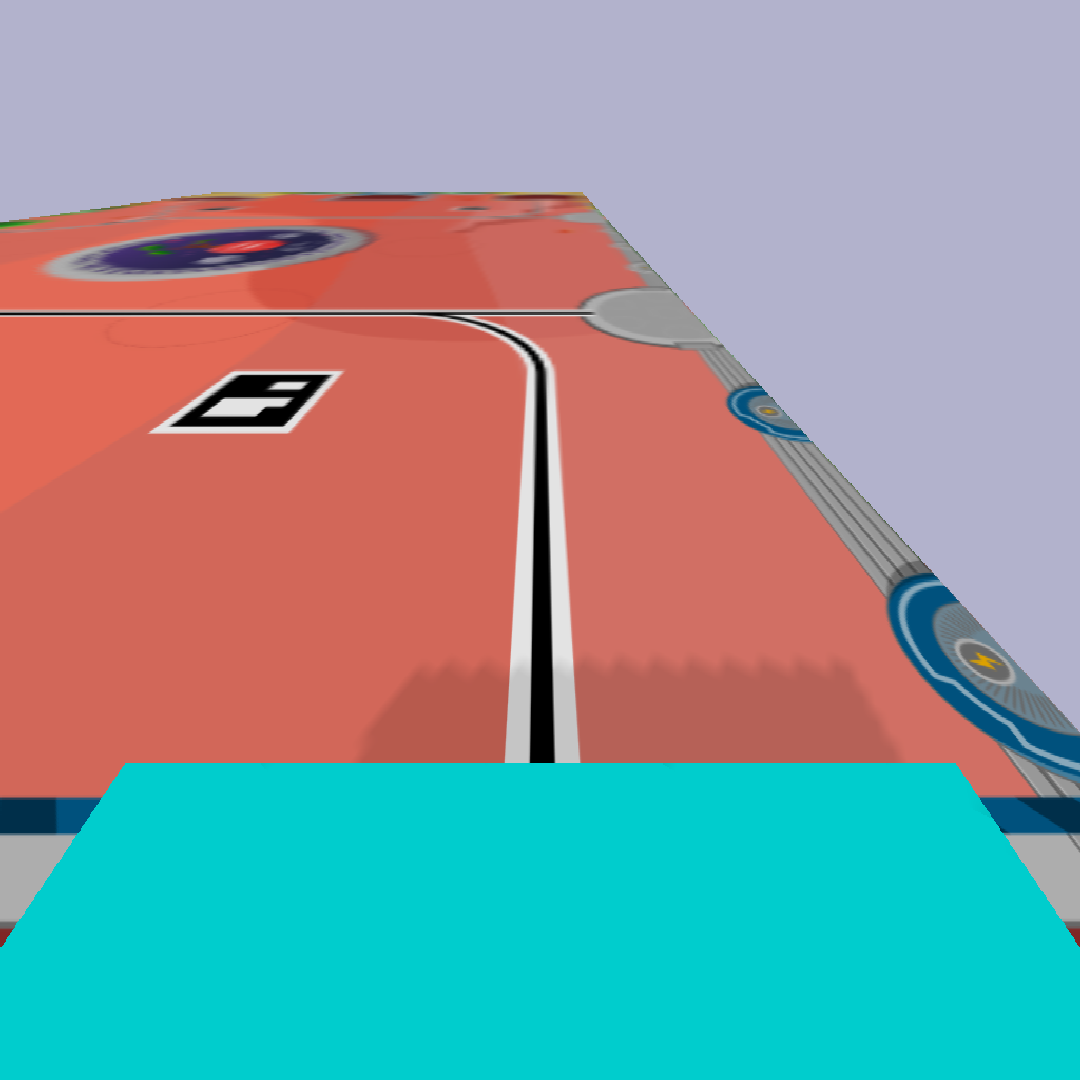

In [14]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "train/ligne_droite/000.png", width = 300, height = 300)

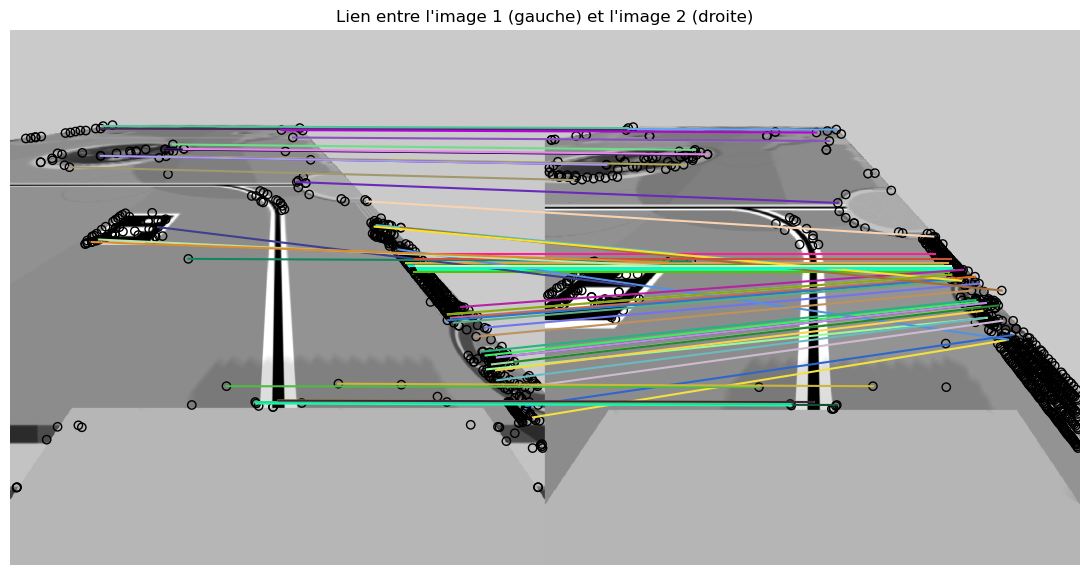

In [15]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

from PIL import Image

image_0 = Image.open("train/ligne_droite/000.png")
image_1 = Image.open("train/ligne_droite/001.png")

# source https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html
img1 = rgb2gray(np.asarray(image_0))
img2 = rgb2gray(np.asarray(image_1))
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                  translation=(0, -200))


descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.6,
                              cross_check=True)

fig, ax = plt.subplots(figsize=(11, 8))

plt.gray()

plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Lien entre l'image 1 (gauche) et l'image 2 (droite)")


plt.tight_layout()
plt.show()

## Dessin technique
Le terrain est également muni de Tag Aruco pouvant permettre une triangulation.